# 2025.09.26 Attitude Telemetry Investigation 

## Setup

My goal with this first experiment is to reproduce the results that John produced here. Specifically,

1. Command the bus to `SunTrack`
2. Command the bus to `Nadir Track`
3. Command the bus to `Sun Track`

Specifically, I excute that with the three following commands at about 5 minute intervals. 

1. `{ time: 2025-09-26T20:46:25.746800Z, content: "E_CMD_HIST: [ OK  ] MDC_SLEW_TRACK SlewTime_s=[0] SlewMode=[0, EigenSlew] TrackMode=[1, SunTrack] ClockingOption=[3, E_SC2NadirCentric]" }`
2. `{ time: 2025-09-26T20:51:43.446475Z, content: "E_CMD_HIST: [ OK  ] MDC_SLEW_TRACK SlewTime_s=[0] SlewMode=[0, EigenSlew] TrackMode=[2, NadirTrack] ClockingOption=[1, E_SC2Sun]" }`
3. `{ time: 2025-09-26T20:55:34.741400Z, content: "E_CMD_HIST: [ OK  ] MDC_SLEW_TRACK SlewTime_s=[0] SlewMode=[0, EigenSlew] TrackMode=[1, SunTrack] ClockingOption=[3, E_SC2NadirCentric]" }`

`Event Manager: EVR_MGR { time: 2025-09-26T18:41:15.916125Z, content: "E_CMD_HIST: [ OK  ] MDC_SLEW_TRACK SlewTime_s=[0] SlewMode=[0, EigenSlew] TrackMode=[2, NadirTrack] ClockingOption=[0, E_FrameFixed]" }`


Let's focus our charts on that time range from **20:40** to **21:00**.


## Notes 
**Clocking option:** 

## Questions 
- It seems like both commands `Nadir track` and `Sun track` effectively just set the quaternions to 0. Why is that.

In [151]:
START_TIME = pd.Timestamp("2025-09-26 20:40:00")
END_TIME = pd.Timestamp("2025-09-26 21:00:00")

In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import pymongoarrow as pma

from pymongoarrow.monkey import patch_all
patch_all()

from pymongo import MongoClient
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# MongoDB connection details
MONGO_IP = "127.0.0.1"
MONGO_PORT = 27017
MONGO_USER = None  # Set to "your_username" if authentication is enabled
MONGO_PASS = None  # Set to "your_password" if authentication is enabled
MONGO_URI = (f"mongodb://{MONGO_USER}:{MONGO_PASS}@{MONGO_IP}:{MONGO_PORT}/?authSource=admin"
             if MONGO_USER and MONGO_PASS
             else f"mongodb://{MONGO_IP}:{MONGO_PORT}/")

# Connect to MongoDB
try:
    client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=5000)
    client.server_info()  # Test connection
    print("Connected to MongoDB successfully!")
except Exception as e:
    print(f"Failed to connect to MongoDB: {e}")
    print("Ensure MongoDB is running on 127.0.0.1:27017 and check authentication credentials.")
    exit(1)

database = client['flatsat']
coll = database['tlm']

Connected to MongoDB successfully!


## 0.0 Access database and collection

In [154]:
# Access the database and collection
database = client['flatsat']
coll = database['tlm']

## 1.0 Attitude Summary
- Quaternion value: attitude of vehicle
- Estimated body rate (rad/s)
- Rate bias: persistent systematic error in the estimate attitude rate of the vehicle (estimated). 

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Define column groups
quaternion_cols = {
    'ATD_QEST_CBI2BDY0': 'Quaternion Body X',
    'ATD_QEST_CBI2BDY1': 'Quaternion Body Y',
    'ATD_QEST_CBI2BDY2': 'Quaternion Body Z', 
    'ATD_QEST_CBI2BDY3': 'Quaternion Body W',
}

# Rate Bias columns
rate_bias_cols = {
    'ATD_RATEBIAS_BDYX': 'Rate Bias Body X',
    'ATD_RATEBIAS_BDYY': 'Rate Bias Body Y',
    'ATD_RATEBIAS_BDYZ': 'Rate Bias Body Z',
}

# Weighted Estimate columns
weighted_est_cols = {
    'ATD_WEST_BDYX': 'Estimated Rate Body X',
    'ATD_WEST_BDYY': 'Estimated Rate Body Y',
    'ATD_WEST_BDYZ': 'Estimated Rate Body Z',
}

# Other relevant columns
other_cols = {
    'ATD_TIMESINCEACCEPTED': 'Time Since Last Accepted (s)',
    'ATD_TOTALREJECTCOUNT': 'Total Reject Count',
}

# Combine all column groups into a single dictionary
attitude_cols = {
    "Quaternion Components": quaternion_cols,
    "Rate Biases [rad/s]": rate_bias_cols,
    "Estimated Rate [rad/s]": weighted_est_cols,
    "Other Metrics": other_cols,
}

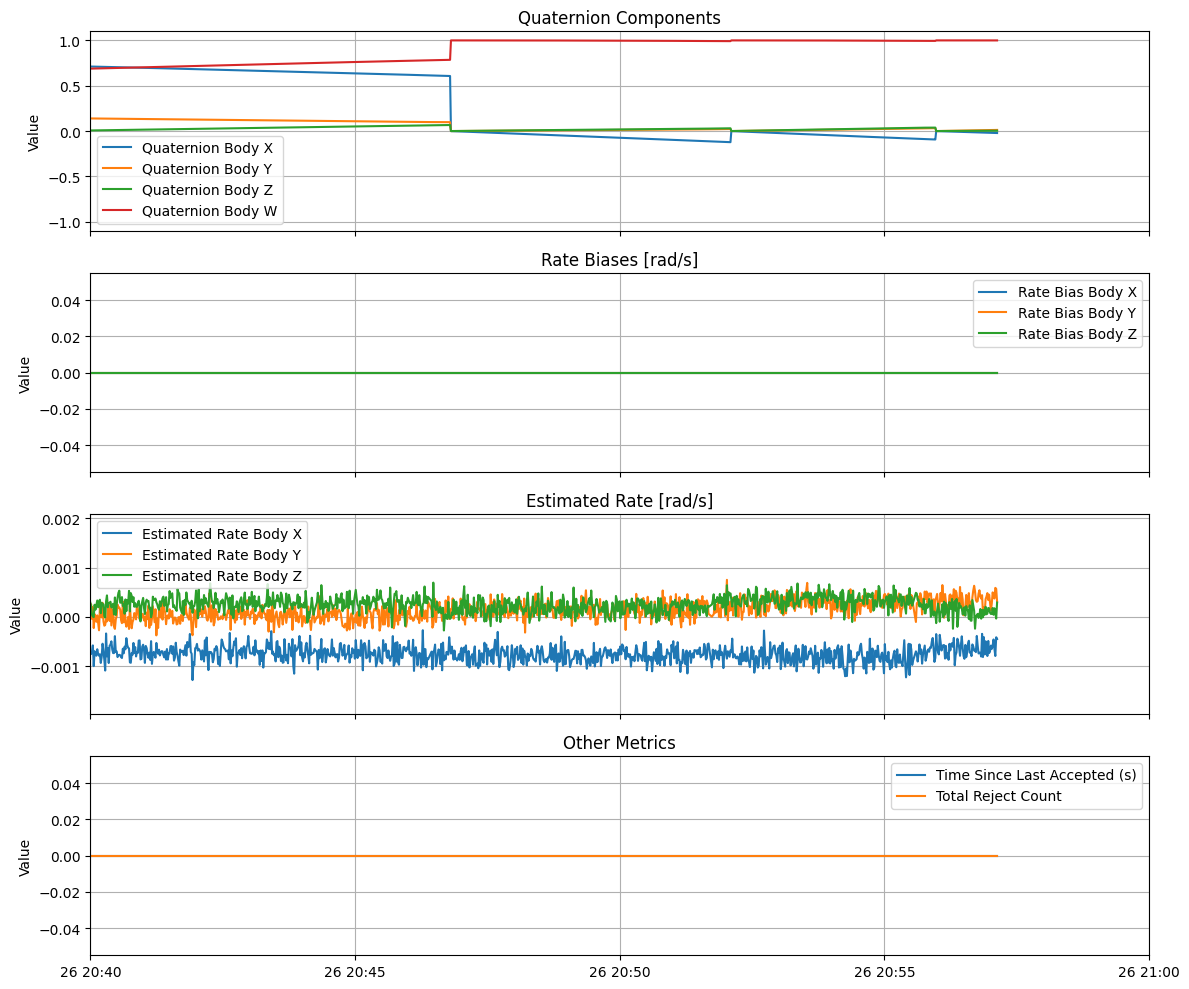

In [156]:
from graph_functions.plot_telemetry import plot_atd_summary

fig, axs = plot_atd_summary(coll, 'ATD_ADSUMMARY', attitude_cols, start_time=START_TIME, end_time=END_TIME)

plt.tight_layout()
plt.show()

## 2.0 Attitude Details (covariance matrix)

- 6 by 6 attitude matrix. First three elements are for attitude (rad) and second three elements are for attitude rate (rad/s)

```
 Mnemonic: ATD_ADDETAILS
 APID: 603
 Data Length: 84 bytes
 Variable Size: False
 ```

In [157]:
import numpy as np 

attitude_covariance = coll.find_pandas_all({'mnemonic': 'ATD_ADDETAILS'})

attitude_covariance.set_index('time', inplace=True)

covariance_matrix = np.zeros((len(attitude_covariance), 6,6))

for i in range(6):
    for j in range(i,6):
        covariance_matrix[:,i,j] = attitude_covariance[f'ATD_COVAR{i}{j}']
    for j in range(i):
        covariance_matrix[:,i,j] = attitude_covariance[f'ATD_COVAR{j}{i}']

print(covariance_matrix[10])

[[2.74155685e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.74155685e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.74155685e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.63251329e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.63251329e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.63251329e-07]]


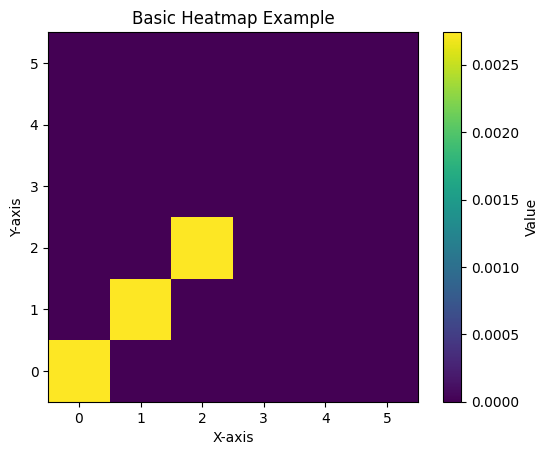

In [158]:
plt.imshow(covariance_matrix[100], cmap='viridis', origin='lower') # 'origin' can be 'upper' or 'lower'
plt.colorbar(label='Value')
plt.title('Basic Heatmap Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## 3.0 Attitude control 

```
 Mnemonic: CAT_FSW_CTRL_ATTITUDE
 APID: 930
 Data Length: 84 bytes
 Variable Size: False
```

In [159]:
# Define column groups
pos_state_cols = {
    'CAT_POSSTATE_ATCX': 'Acceleration command from the position error in attitude controller frame X',
    'CAT_POSSTATE_ATCY': 'Acceleration command from the position error in attitude controller frame Y',
    'CAT_POSSTATE_ATCZ': 'Acceleration command from the position error in attitude controller frame Z',
}

rt_state_cols = {
    'CAT_RTESTATE_ATCX': 'Acceleration command from the rate error in attitude controller frame X',
    'CAT_RTESTATE_ATCY': 'Acceleration command from the rate error in attitude controller frame Y',
    'CAT_RTESTATE_ATCZ': 'Acceleration command from the rate error in attitude controller frame Z',
}

int1_state_cols = {
    'CAT_INT1STATE_ATCX': 'Acceleration command from the first integral in attitude controller frame XX',
    'CAT_INT1STATE_ATCY': 'Acceleration command from the first integral in attitude controller frame Y',
    'CAT_INT1STATE_ATCZ': 'Acceleration command from the first integral in attitude controller frame Z',
}

int2_state_cols = {
    'CAT_INT2STATE_ATCX': 'Acceleration command from the second integral in attitude controller frame X',
    'CAT_INT2STATE_ATCY': 'Acceleration command from the second integral in attitude controller frame Y',
    'CAT_INT2STATE_ATCZ': 'Acceleration command from the second integral in attitude controller frame Z',
}

ffwtrq_state_cols = {
    'CAT_FFWTRQSTATE_ATCX': 'Torque command from feed forward in attitude controller frame X',
    'CAT_FFWTRQSTATE_ATCY': 'Torque command from feed forward in attitude controller frame Y',
    'CAT_FFWTRQSTATE_ATCZ': 'Torque command from feed forward in attitude controller frame Z',
}

trqcmd_atc_cols = {
    'CAT_TRQCMD_ATCX': 'Total torque command in attitude controller frame X',
    'CAT_TRQCMD_ATCY': 'Total torque command in attitude controller frame Y',
    'CAT_TRQCMD_ATCZ': 'Total torque command in attitude controller frame Z',
}

trqcmd_body_cols = {
    'CAT_TRQCMD_BDYX': 'Total torque command in body frame X',
    'CAT_TRQCMD_BDYY': 'Total torque command in body frame Y',
    'CAT_TRQCMD_BDYZ': 'Total torque command in body frame Z',
}

# Combine all column groups into a single dictionary
control_attitude_cols = {
    "Acceleration command from the position error n attitude controller frame": pos_state_cols,
    "Acceleration command from the rate error in attitude controller frame": rt_state_cols,
    "Acceleration command from the first integral in attitude controller frame": int1_state_cols,
    "Acceleration command from the second integral in attitude controller frame": int2_state_cols,
    "Torque command from feed forward in attitude controller frame": ffwtrq_state_cols,
    "Total torque command in attitude controller frame": trqcmd_atc_cols,
    "Total torque command in body frame": trqcmd_body_cols,
}

units = ['rad/s^2', 'rad/s^2', 'rad/s^2', 'rad/s^2', 'Nm', 'Nm', 'Nm']

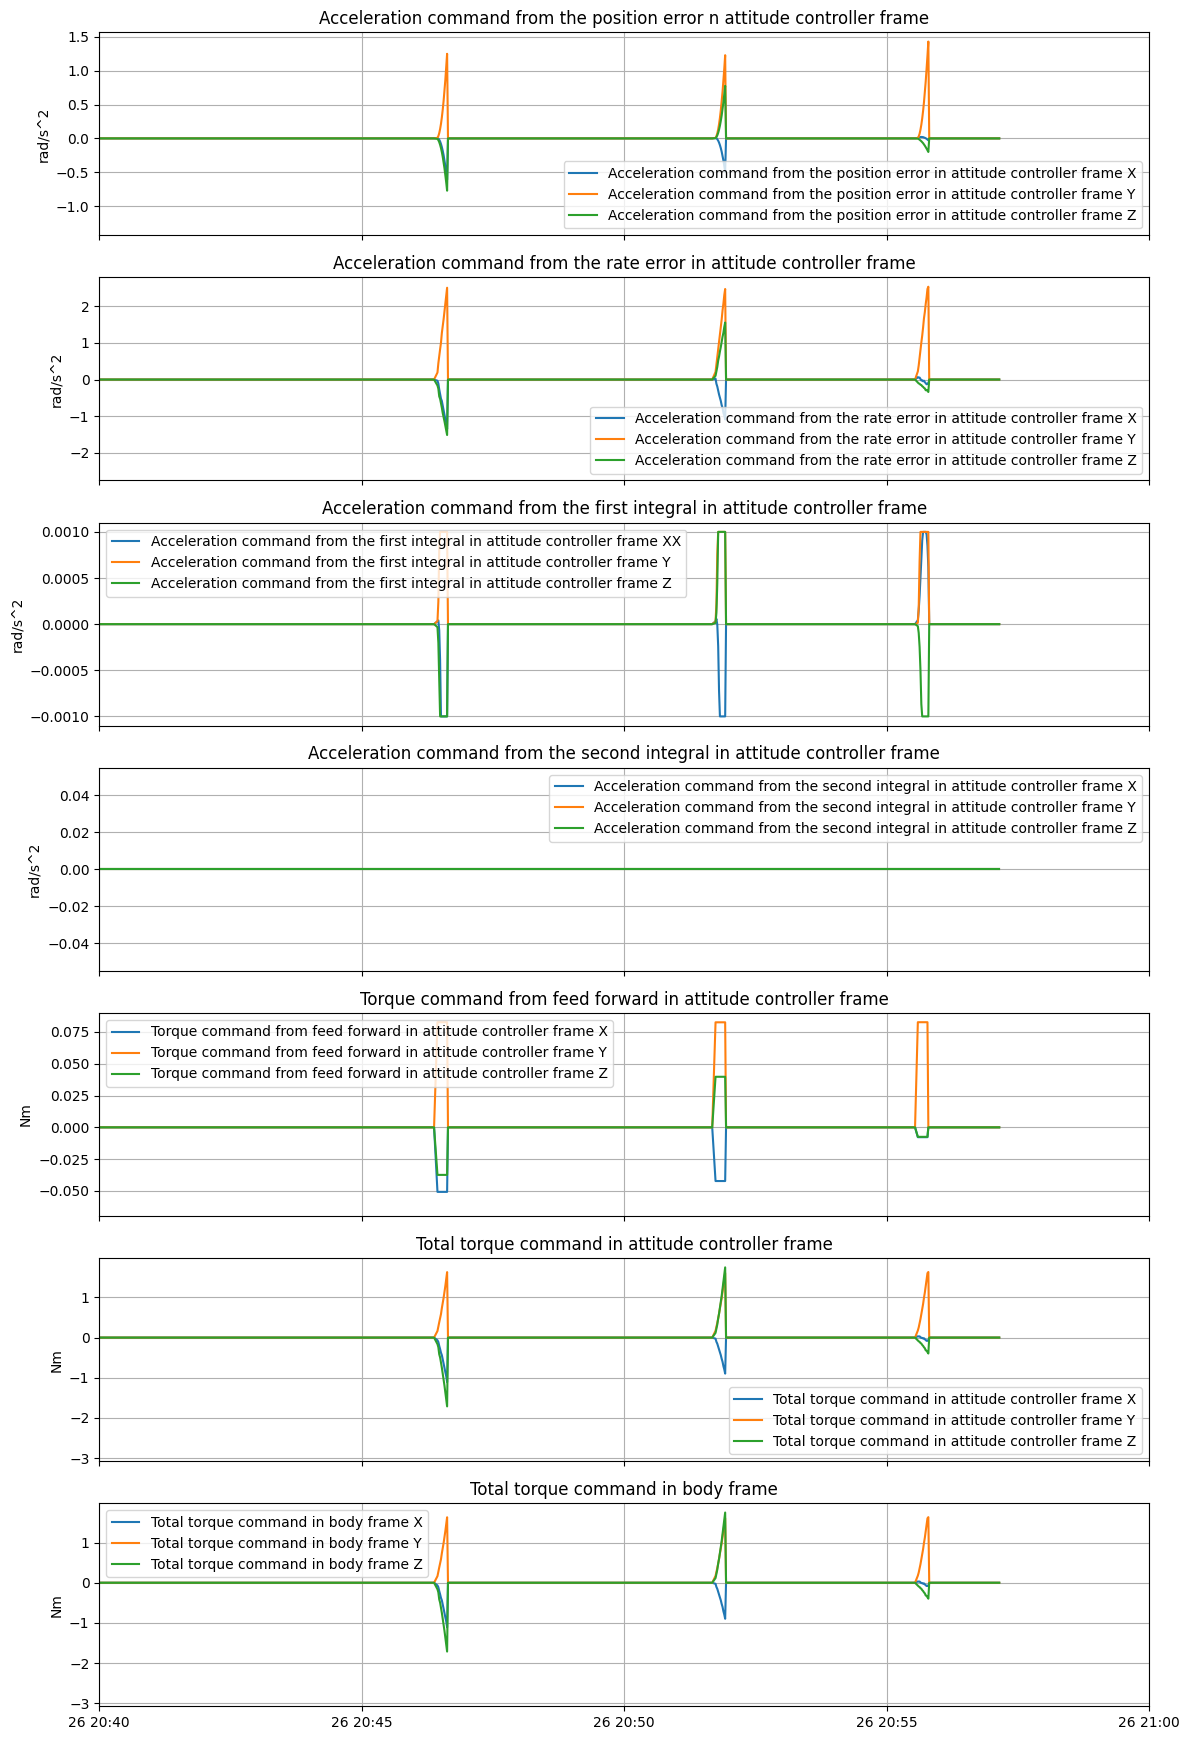

In [160]:
from graph_functions.plot_telemetry import plot_atd_summary

fig, axs = plot_atd_summary(coll, 'CAT_FSW_CTRL_ATTITUDE', control_attitude_cols, start_time=START_TIME, end_time=END_TIME, units=units)

plt.tight_layout()
plt.show()

## 4.0 Control error gen

```
FSW_Ctrl_ErrorGen

 Mnemonic: CEG_FSW_CTRL_ERRORGEN
 APID: 900
 Data Length: 32 bytes
 Variable Size: False
```

In [161]:
att_control_error_gen = {
    'CEG_ATTERR_BDYX': 'X-Axis Component Of Spacecraft Controller Attitude Error',
    'CEG_ATTERR_BDYY': 'Y-Axis Component Of Spacecraft Controller Attitude Error',
    'CEG_ATTERR_BDYZ': 'Z-Axis Component Of Spacecraft Controller Attitude Error',
    'CEG_ATTERRMAG': 'Spacecraft Controller Attitude Error Magnitude',
}

rate_control_error_gen = {
    'CEG_RATEERR_BDYX': 'X-Axis Component Of Spacecraft Controller Rate Error',
    'CEG_RATEERR_BDYY': 'Y-Axis Component Of Spacecraft Controller Rate Error',
    'CEG_RATEERR_BDYZ': 'Z-Axis Component Of Spacecraft Controller Rate Error',
    'CEG_RATEERRMAG': 'Spacecraft Controller Rate Error Magnitude',
}

control_error_cols = {
    'Spacecraft Controller Attitude Error': att_control_error_gen,
    'Spacecraft Controller Rate Error': rate_control_error_gen
}

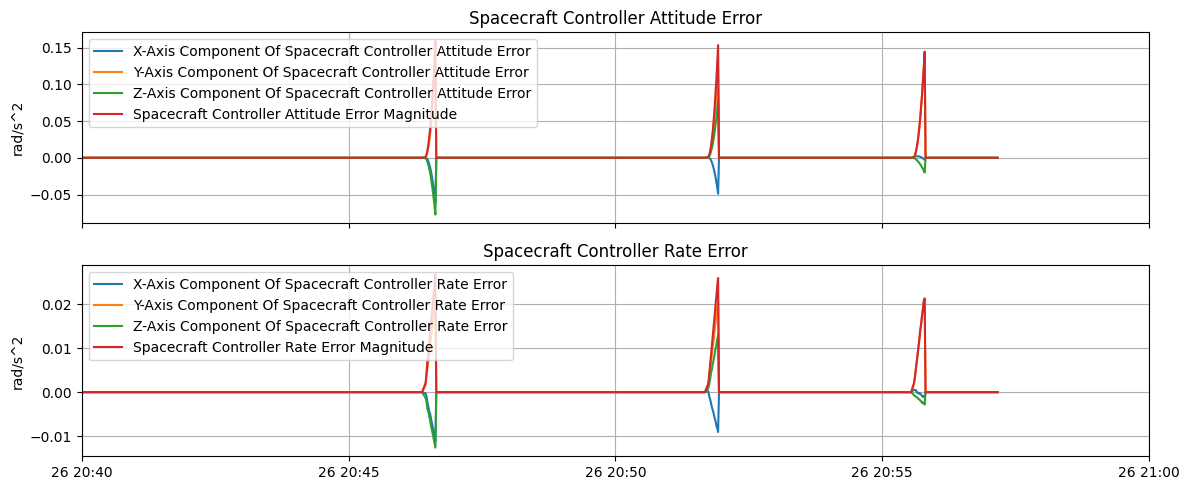

In [162]:
fig, axs = plot_atd_summary(coll, 'CEG_FSW_CTRL_ERRORGEN', control_error_cols, start_time=START_TIME, end_time=END_TIME, units=units)

plt.tight_layout()
plt.show()

## 5.0 Feed FSW control 
- Includes channels for both *Feed forward control torque* and *Feed forward gyro torque*
- Gyro torque
    - Torque exerted by reaction wheels and such
    - Total feed forward torque also includes torque on the vehicle due to external sources like the gravity perterbations of the earth.


```
Mnemonic: CFF_FSW_CTRL_FEEDFORWARD
 APID: 920
 Data Length: 24 bytes
 Variable Size: False
```

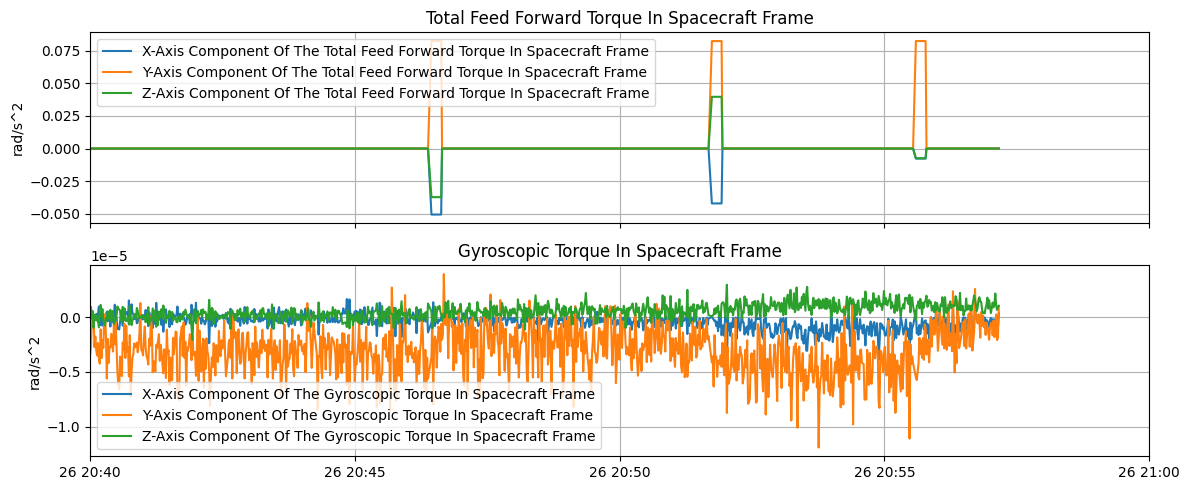

In [163]:
feed_forward_total_torque = {
    "CFF_TOTTRQ_BDYX": "X-Axis Component Of The Total Feed Forward Torque In Spacecraft Frame",
    "CFF_TOTTRQ_BDYY": "Y-Axis Component Of The Total Feed Forward Torque In Spacecraft Frame",
    "CFF_TOTTRQ_BDYZ": "Z-Axis Component Of The Total Feed Forward Torque In Spacecraft Frame",
}

feed_forward_gyroscope_torque = {
    "CFF_GYROTRQ_BDYX": "X-Axis Component Of The Gyroscopic Torque In Spacecraft Frame",
    "CFF_GYROTRQ_BDYY": "Y-Axis Component Of The Gyroscopic Torque In Spacecraft Frame",
    "CFF_GYROTRQ_BDYZ": "Z-Axis Component Of The Gyroscopic Torque In Spacecraft Frame",

}

feed_forward_torque = {
    "Total Feed Forward Torque In Spacecraft Frame": feed_forward_total_torque,
    "Gyroscopic Torque In Spacecraft Frame": feed_forward_gyroscope_torque,
}

fig, axs = plot_atd_summary(coll, 'CFF_FSW_CTRL_FEEDFORWARD', feed_forward_torque, start_time=START_TIME, end_time=END_TIME, units=units)

plt.tight_layout()
plt.show()

## 6.0 Momentum control 

FSW_Ctrl_Momentum

```
 Mnemonic: CMC_FSW_CTRL_MOMENTUM
 APID: 910
 Data Length: 52 bytes
 Variable Size: False
```

### Momentum controller frame? 

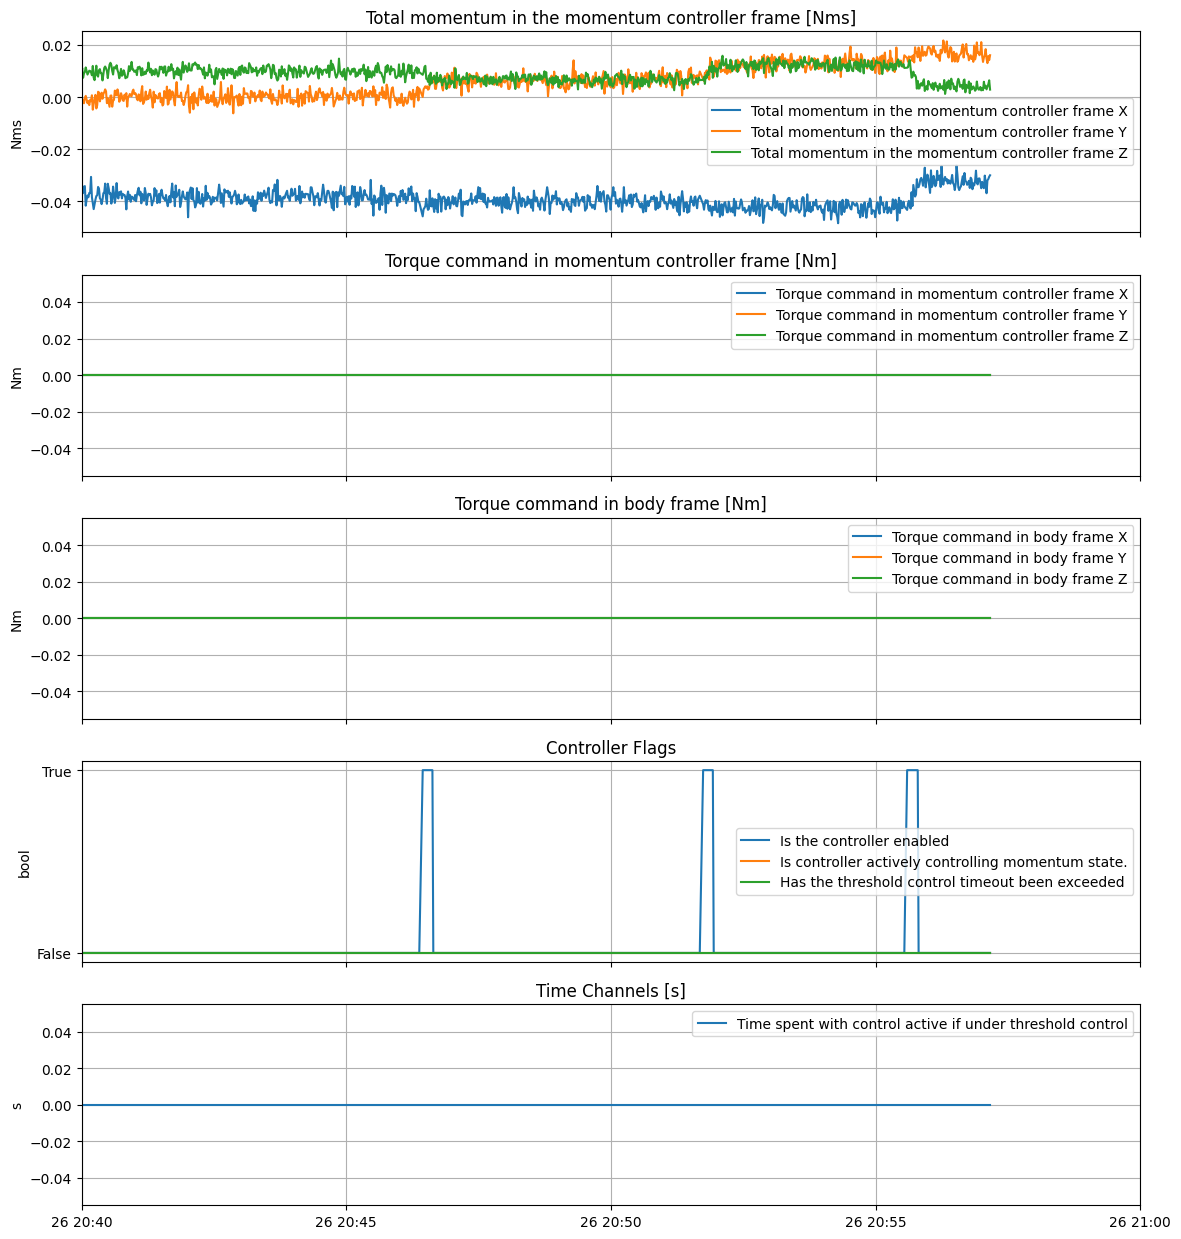

In [164]:
momentum_control = {
    "CMC_TOTMOM_MMCX": "Total momentum in the momentum controller frame X",
    "CMC_TOTMOM_MMCY": "Total momentum in the momentum controller frame Y",
    "CMC_TOTMOM_MMCZ": "Total momentum in the momentum controller frame Z",
}

torque_momentum_frame = {
    "CMC_TRQCMD_MMCX": "Torque command in momentum controller frame X",
    "CMC_TRQCMD_MMCY": "Torque command in momentum controller frame Y",
    "CMC_TRQCMD_MMCZ": "Torque command in momentum controller frame Z",
}

torque_body_frame = {
    "CMC_TRQCMD_BDYX": "Torque command in body frame X",
    "CMC_TRQCMD_BDYY": "Torque command in body frame Y",
    "CMC_TRQCMD_BDYZ": "Torque command in body frame Z",
}

flags = {
    "CMC_ENABLED": "Is the controller enabled",
    "CMC_INPROGRESS": "Is controller actively controlling momentum state.",
    "CMC_THRESHCTRLTIMEREXCEED": "Has the threshold control timeout been exceeded",
}

time_channels = {
    "CMC_THRESHCTRLTIMER": "Time spent with control active if under threshold control",
}

momentum_control_cols = {
    "Total momentum in the momentum controller frame [Nms]": momentum_control,
    "Torque command in momentum controller frame [Nm]": torque_momentum_frame,
    "Torque command in body frame [Nm]": torque_body_frame,
    "Controller Flags": flags,
    "Time Channels [s]": time_channels,
}

units = ['Nms', 'Nm', 'Nm', 'bool', 's']

fig, axs = plot_atd_summary(coll, 'CMC_FSW_CTRL_MOMENTUM', momentum_control_cols, start_time=START_TIME, end_time=END_TIME, units=units)

plt.tight_layout()
plt.show()

## 7.0 Accuator control 

In [165]:
def return_rw_cols(num):
    times = {
        f"RWP{num}_TIMESINCELASTVAL": "Time since the last valid speed measurement",
    }

    flags = {
        f"RWP{num}_SPEEDAVAIL": "Is speed avaliable",
    }

    speeds = {
        f"RWP{num}_FILTSPEED": "Filtered speed",
        f"RWP{num}_MEASSPEED": "Measured speed",
        f"RWP{num}_SPEEDCMD": "Commanded wheel speed",
    }

    momentum = {
        f"RWP{num}_MOMENTUM": "Wheel momentum",
    }

    torque = {
        f"RWP{num}_TRQCMD": "Commanded wheel torque",
        f"RWP{num}_TRQACSPEEDERRORINTTORQUET": "Wheel speed controller integral state",
    }

    rw_cols = {
        "Time Channels [s]": times,
        "Flags": flags,
        "Speeds [rad/s]": speeds,
        "Momentum [Nms]": momentum,
        "Torque [Nm]": torque,
    }

    return rw_cols

### 7.1 RW1

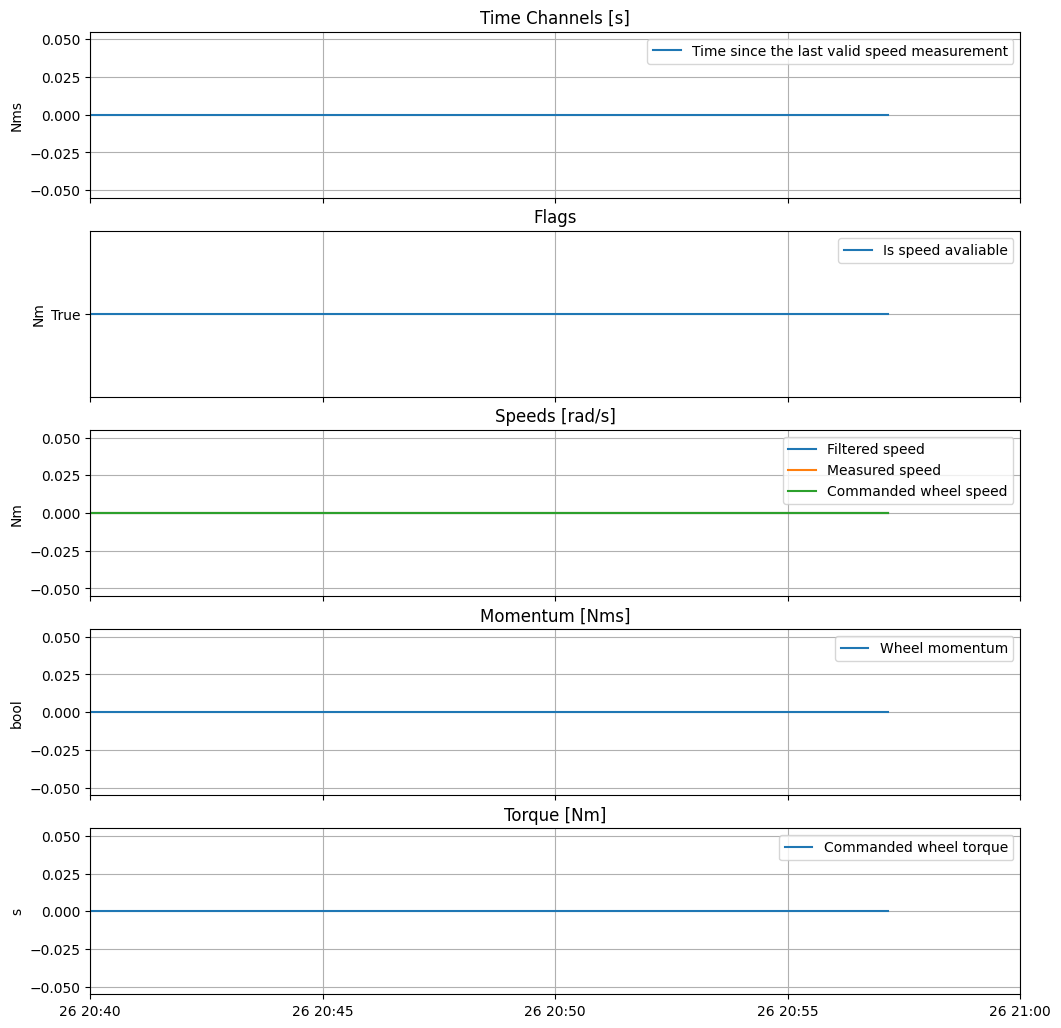

In [166]:
rw_num = 1
cols = return_rw_cols(rw_num)
fig, axs = plot_atd_summary(coll, f'RWP{rw_num}_FSC_ACTPROC_RW', cols, start_time=START_TIME, end_time=END_TIME, units=units)

### 7.2 RW2

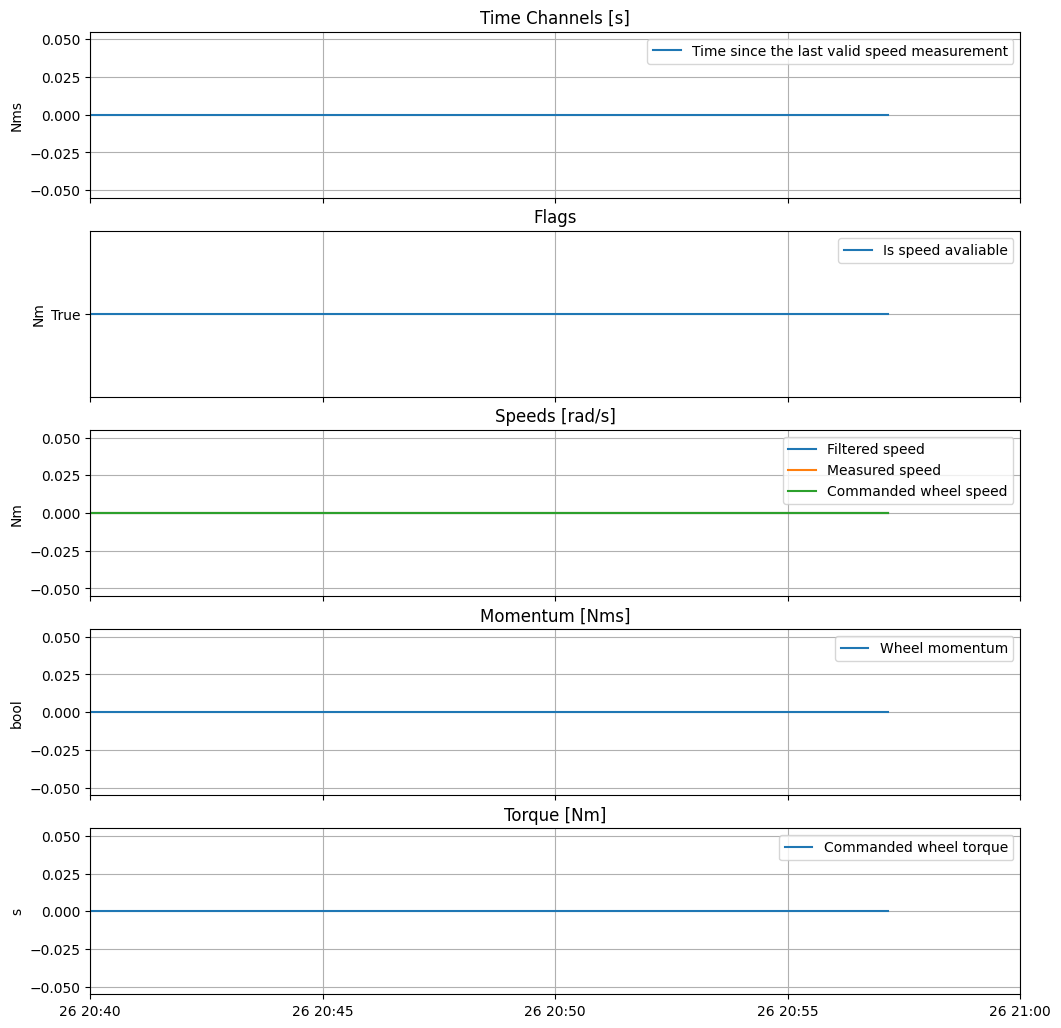

In [167]:
rw_num = 1
cols = return_rw_cols(rw_num)
fig, axs = plot_atd_summary(coll, f'RWP{rw_num}_FSC_ACTPROC_RW', cols, start_time=START_TIME, end_time=END_TIME, units=units)

### 7.3 RW3

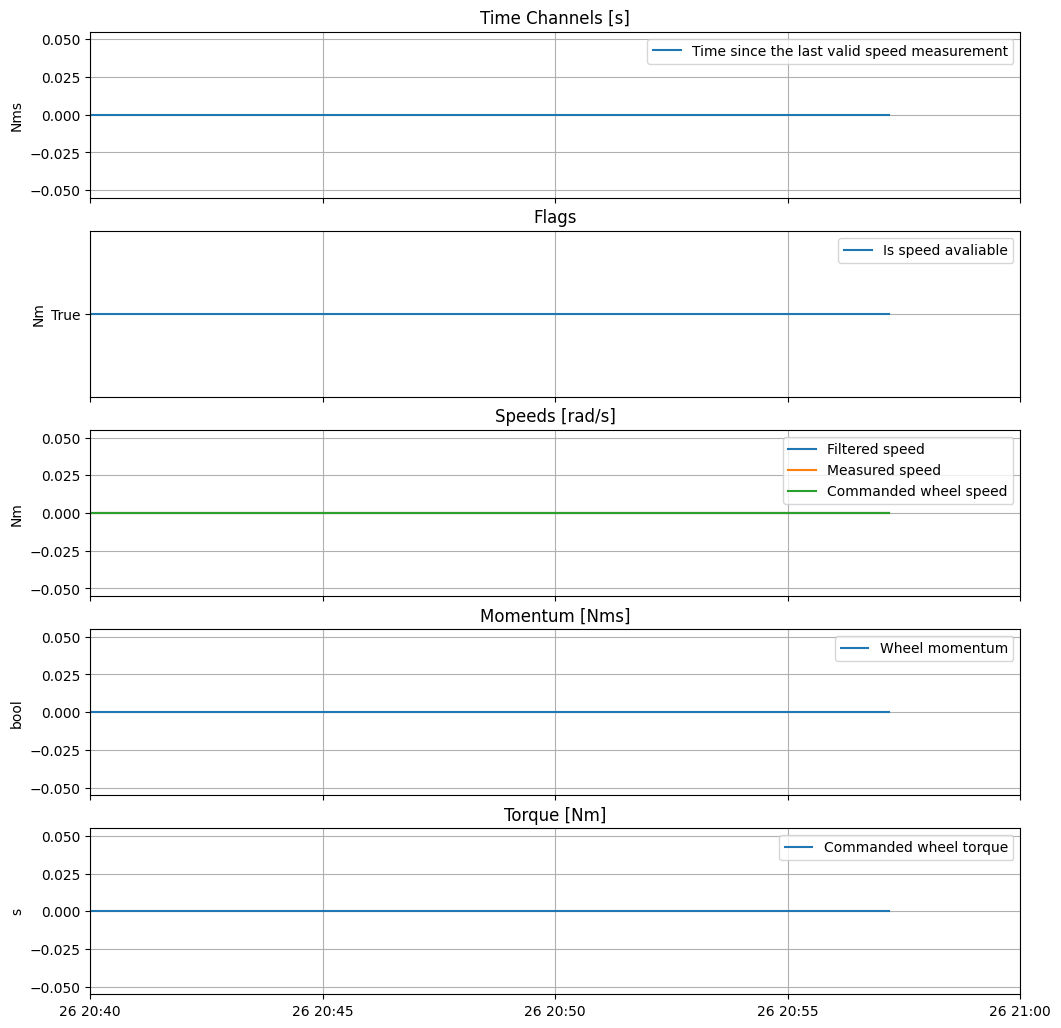

In [168]:
rw_num = 1
cols = return_rw_cols(rw_num)
fig, axs = plot_atd_summary(coll, f'RWP{rw_num}_FSC_ACTPROC_RW', cols, start_time=START_TIME, end_time=END_TIME, units=units)

### 7.4 RW4

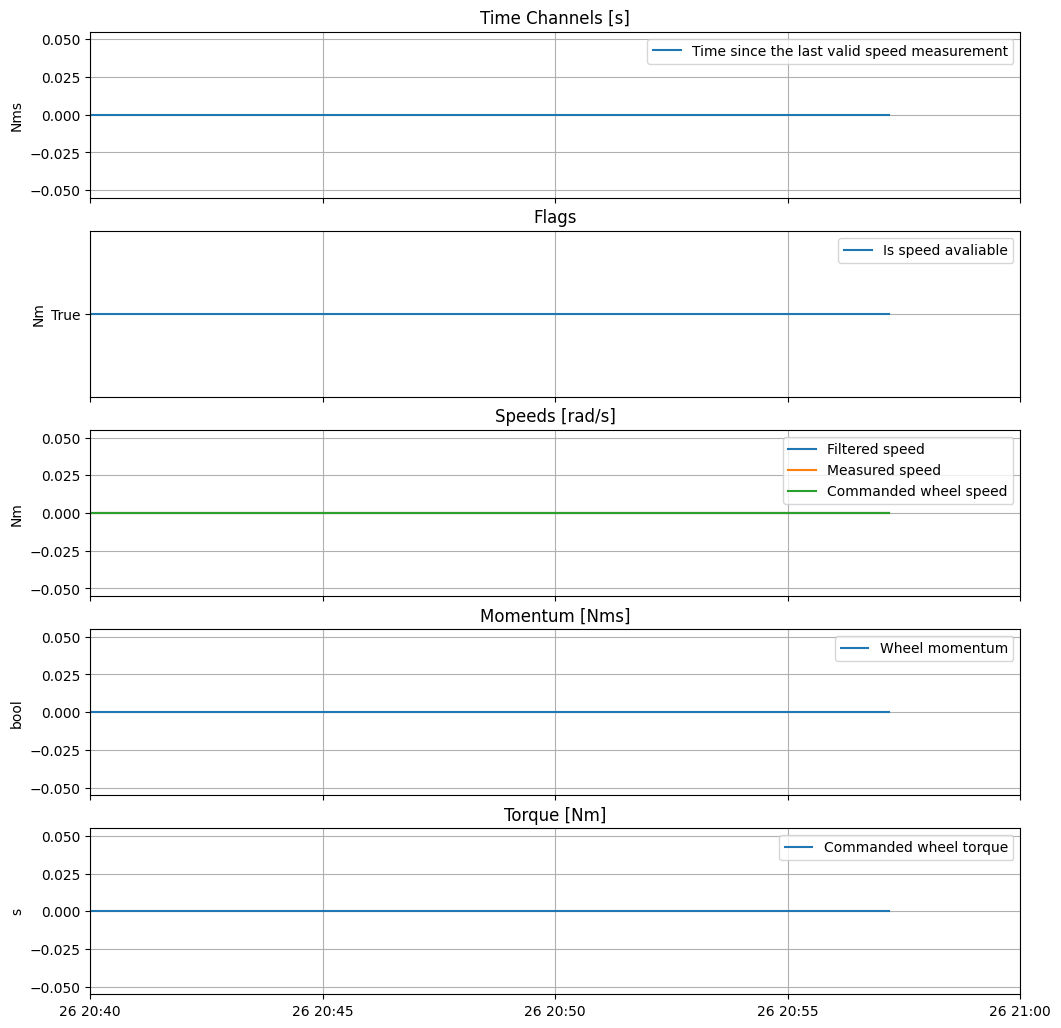

In [169]:
rw_num = 1
cols = return_rw_cols(rw_num)
fig, axs = plot_atd_summary(coll, f'RWP{rw_num}_FSC_ACTPROC_RW', cols, start_time=START_TIME, end_time=END_TIME, units=units)